# Работа с текстом

#### Содержание
- [Bag of words](#Bag-of-words)
- [TF-IDF](#TF-IDF)
- [Визуализация эмбеддингов текстов](#Визуализация-эмбеддингов-текстов)
- [Поиск похожих документов](#Поиск-похожих-документов)
- [Обработка текста](#Обработка-текста)
    - [Токенизация](#Токенизация)
    - [Удаление стоп слов](#Удаление-стоп-слов)
    - [Стемминг](#Стемминг)
    - [Лемматизация](#Лемматизация)
- [Тематическое моделирование текста](#Тематическое-моделирование-текста)
- [Эмбеддинги слов](#Эмбеддинги-слов)

In [1]:
import os
import re
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from tqdm import tqdm
from wordcloud import WordCloud

from sklearn.metrics import accuracy_score
from sklearn.linear_model import LogisticRegression
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer


In [2]:
os.chdir('../../')

In [3]:
base_data_path = 'data/datasets/ag_news'

train_data_path = os.path.join(base_data_path, 'ag_news_train.csv')
test_data_path = os.path.join(base_data_path, 'ag_news_test.csv')

In [4]:
data_train = pd.read_csv(train_data_path, sep='\t')
data_test = pd.read_csv(test_data_path,  sep='\t')

In [5]:
data_train.head(3)

,text,label
0,Wall St. Bears Claw Back Into the Black (Reute...,2
1,Carlyle Looks Toward Commercial Aerospace (Reu...,2
2,Oil and Economy Cloud Stocks' Outlook (Reuters...,2


In [6]:
labels_train = data_train['label']
labels_test = data_test['label']

corpus_train = data_train['text']
corpus_test = data_test['text']

print(len(labels_train))
print(len(labels_test))

120000
7600


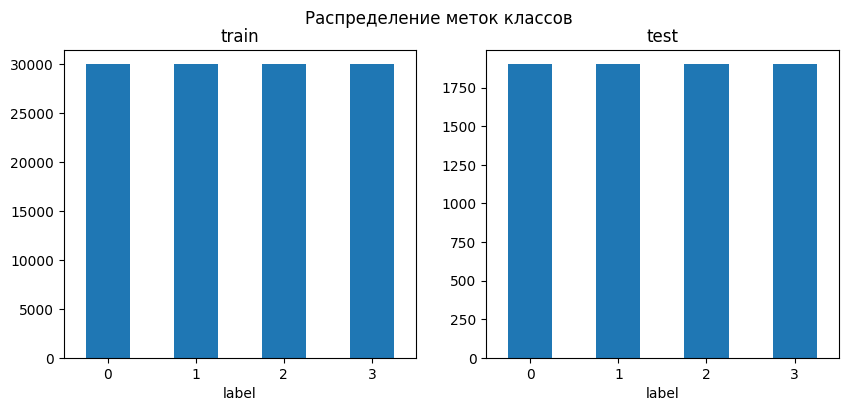

In [7]:
fig, ax = plt.subplots(1,2, figsize=(10,4))

labels_train.value_counts().sort_index().plot(
    kind='bar',rot=0, title='train', ax=ax[0])

labels_test.value_counts().sort_index().plot(
    kind='bar',rot=0, title='test', ax=ax[1])

plt.suptitle('Распределение меток классов')
plt.show() 

In [8]:
def show_wordcloud_plot(corpus):
    wordcloud = WordCloud(
        max_words=200, background_color='white', collocations=True
    ).generate(' '.join(corpus))
    plt.figure(figsize=(10, 6))
    plt.imshow(wordcloud)
    plt.axis('off')
    plt.show() 

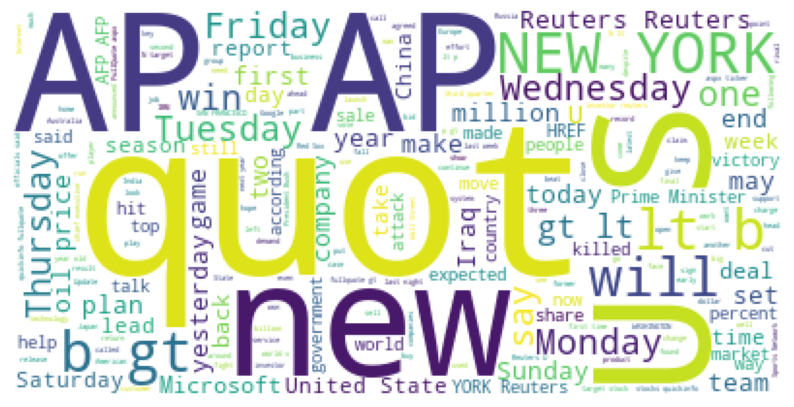

In [9]:
show_wordcloud_plot(data_train['text'])

## Bag of words

**Bag of words** - модель представления текста, где текст рассматривается как неупорядоченный набор слов (мешок), без учета грамматики и порядка слов.

1. **Токенизация**: Разбиение текста на слова.
2. **Создание словаря**: Уникальные слова из всех документов.
3. **Векторизация**: Каждый документ → вектор, где элемент = частота слова в словаре.

In [10]:
bow_vectorizer = CountVectorizer(
    lowercase=True,               # Приводить ли текст к нижнему регистру перед токенизацией
    stop_words=None,              # Удаление стоп-слов
    ngram_range=(1,1),            # Диапазон n-грамм
    min_df=4,                     # Удалит слова, встречающиеся < n раз
    max_df=0.95,                  # Игнорировать токены, встречающиеся чаще указанного порога
    max_features=30000,           # Ограничение на количество фичей (отбираются топ-N частых токенов)
)
bow_vectorizer.fit(corpus_train);

In [11]:
X_train = bow_vectorizer.transform(corpus_train)
X_test = bow_vectorizer.transform(corpus_test)

print(f'Words amount: {X_train.shape[1]}')

Words amount: 29350


In [12]:
def train_eval_model(X_train, X_test, y_train, y_test):
    model = LogisticRegression(
        penalty='l2',             # Тип регуляризации
        C=1,                      # Сила регуляризации
        max_iter=1000,            # Макс. число итераций оптимизации
        class_weight='balanced',  # Балансировка классов
        random_state=42           # Фиксация случайности 
        
    )
    model.fit(X_train, y_train)
    
    pred_train = model.predict(X_train)
    pred_test = model.predict(X_test)
    
    train_acc = accuracy_score(y_train, pred_train)
    test_acc = accuracy_score(y_test, pred_test)
    
    print(f'Train accuracy: {train_acc:.3f}')
    print(f'Test accuracy: {test_acc:.3f}')

In [18]:
train_eval_model(X_train, X_test, labels_train, labels_test)

Train accuracy: 0.977
Test accuracy: 0.909


## TF-IDF

1. __Term frequency__:
$$\text{tf}(t, d) = \frac{N(t, d)}{\sum_{k \in V} N(k, d)},$$
где $N(t, d)$ — количество вхождений слова $t$ в текст $d$.
1. __Inverse Document Frequency__
$$\text{idf}(t, D) = \log \frac{|D|}{|\{d \in D | t \in d\}|},$$

где $\left| \{d\in D: t \in d\} \right|$ – количество текстов в коллекции, содержащих слово $t$.


$$\text{tf-idf}(t,d, D) = \text{tf}(t, d)\cdot \text{idf}(t, D).$$


In [13]:
tfidf_vectorizer = TfidfVectorizer(
    lowercase=True,                  # Приводить текст к нижнему регистру
    stop_words=None,                 # Стоп-слова 
    ngram_range=(1, 1),              # Диапазон n-грамм
    min_df=4,                        # Удалит слова, встречающиеся < n раз
    max_df=0.95,                     # Игнорировать токены, встречающиеся чаще указанного порога
    max_features=30000               # Ограничение на количество фичей (отбираются топ-N частых токенов)
    
)

tfidf_vectorizer.fit(corpus_train);

In [14]:
X_train = tfidf_vectorizer.transform(corpus_train)
X_test = tfidf_vectorizer.transform(corpus_test)

print(f'Words amount: {X_train.shape[1]}')

Words amount: 29350


In [21]:
train_eval_model(X_train, X_test, labels_train, labels_test)

Train accuracy: 0.940
Test accuracy: 0.918


## Визуализация эмбеддингов текстов

In [15]:
from sklearn.manifold import TSNE

tsne = TSNE(
    n_components=2,      # Размерность выходного пространства
    perplexity=30,       # Баланс между локальной/глобальной структурой. Чем больше данных, тем выше можно ставить.
    learning_rate=200,   # Скорость обучения. Для больших данных можно увеличивать.
    random_state=42,     # Фиксация случайности 
    init='random'        # Инициализация
)

tsne_vectors = tsne.fit_transform(X_train[:2000])
print(f'tsne_vectors size: {tsne_vectors.shape}')

tsne_vectors size: (2000, 2)


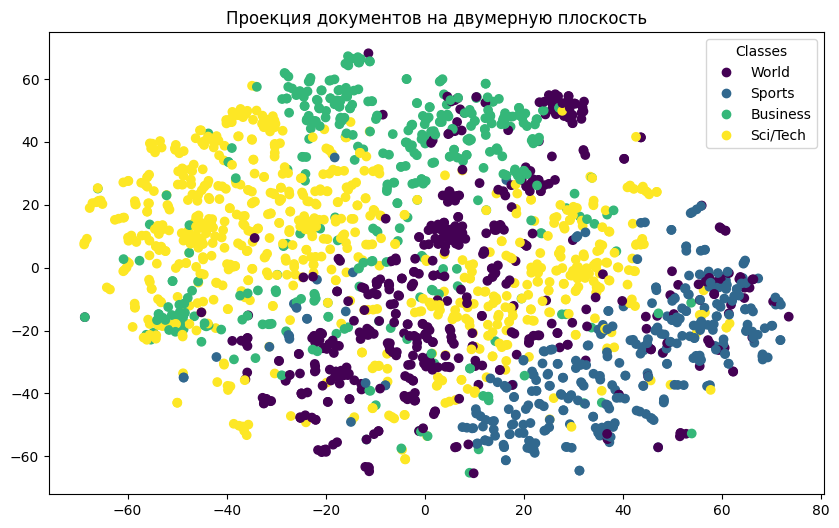

In [16]:
colors = labels_train[:2000]
classes = ['World', 'Sports', 'Business', 'Sci/Tech']

plt.figure(figsize=(10,6))
scatter = plt.scatter(
    x=tsne_vectors[:, 0],
    y=tsne_vectors[:, 1],
    c=colors
)

plt.title('Проекция документов на двумерную плоскость')
plt.legend(scatter.legend_elements()[0], classes, title='Classes')
plt.show()

## Поиск похожих документов

Функция косинусного сходства между вектором и матрицей векторов:

$$
\text{cosine}(\mathbf{v}, \mathbf{M}) = \mathbf{v} \cdot \left( \frac{\mathbf{M}^T}{\|\mathbf{M}\|_2} \right)
$$

где:
- $\mathbf{v}$ — входной вектор
- $\mathbf{M} = [\mathbf{m}_1, \mathbf{m}_2, \dots, \mathbf{m}_n]^T$ — матрица векторов
- $\|\mathbf{M}\|$ — L2-норма (евклидова длина) матрицы $\mathbf{M}$

In [17]:
texts = corpus_train[:2000]
texts_embeddings = tfidf_vectorizer.transform(texts).toarray()

In [18]:
def cosine(emb, embs):
    normed_embs = embs.T / np.linalg.norm(embs, axis=1)
    return emb @ normed_embs

def find_nearest(query, k: int=10):
    embedding = tfidf_vectorizer.transform([query])
    similarities = cosine(embedding, texts_embeddings)[0]
    nearest_idxs = np.argsort(similarities)[-k:][::-1]
    return texts[nearest_idxs]

In [19]:
nearest = find_nearest("Wall Street", k=5)
counter = 0
for text in nearest:
    print(text)
    print()

Wall Street to Open Little Changed  NEW YORK (Reuters) - Wall Street is seen opening little  changed on Monday as crude prices remain high, but insurers may  dip on worries about their potential liabilities after a  hurricane struck Florida on Friday.

Wall St. Bears Claw Back Into the Black  NEW YORK (Reuters) - Short-sellers, Wall Street's dwindling  band of ultra-cynics, are seeing green again.

Wall St. Bears Claw Back Into the Black (Reuters) Reuters - Short-sellers, Wall Street's dwindling\band of ultra-cynics, are seeing green again.

Stocks End Sharply Higher as Oil Prices Drop A pull back in oil prices and upbeat outlooks from Wal-Mart and Lowe's prompted new bargain-hunting on Wall Street today.

Lowe's Reports Increase in Second-Quarter Net Income Lowe's reported a 17.9 percent increase in net income during its second quarter, but results missed Wall Street expectations.



## Обработка текста

### Токенизация

**Токенизация** — это процесс разбиения текста на отдельные токены (части), которые могут быть словами, символами, субсловами или другими лингвистическими единицами.



In [20]:
def tokenize_text(texts):
    return [re.findall(r'\w+', text.lower()) for text in tqdm(texts)]

In [21]:
data_tokenized_train = tokenize_text(corpus_train)
data_tokenized_test = tokenize_text(corpus_test)

100%|████████████████████████████████████| 7600/7600 [00:00<00:00, 88800.49it/s]


### Удаление стоп слов

In [24]:
from nltk.corpus import stopwords
stop_words = stopwords.words('english')
stop_words += ['ap', 'us', 'u', '39']

In [25]:
def remove_stopwords(tokenized_texts):
    return [
        [word for word in words if word not in stop_words] 
            for words in tqdm(tokenized_texts)
    ]

In [26]:
data_tokenized_train = remove_stopwords(data_tokenized_train)
data_tokenized_test = remove_stopwords(data_tokenized_test)

100%|████████████████████████████████████| 7600/7600 [00:00<00:00, 13182.38it/s]


### Стемминг

**Стемминг (от англ. stemming)** – это процесс приведения слова к его основе (корню) путем отсечения аффиксов (окончаний, приставок, суффиксов).

|Исходное слово| Основа (стем)|
|--------------|--------------|
|играть |игр |
|играю | игр |
|играет | игр |
|играли | игр |
|играющий | игр |


**Для английского языка**
- `nltk.stem.PorterStemmer` 
- `nltk.stem.SnowballStemmer`

**Для русского языка**
- `nltk.stem.SnowballStemmer(language="russian")`

In [27]:
from nltk.stem import PorterStemmer

def stem_text(tokenized_text):
    stemmer = PorterStemmer()
    return [
        [stemmer.stem(word) for word in words]
            for words in tqdm(tokenized_text)
    ]

In [28]:
data_stemmed_train = stem_text(data_tokenized_train)
data_stemmed_text = stem_text(data_tokenized_test)

100%|█████████████████████████████████████| 7600/7600 [00:02<00:00, 2845.05it/s]


In [29]:
pd.DataFrame(
    data={
        "word": data_tokenized_train[0],
        "stemmed_word": data_stemmed_train[0]
    }
).head(10)

,word,stemmed_word
0,wall,wall
1,st,st
2,bears,bear
3,claw,claw
4,back,back
5,black,black
6,reuters,reuter
7,reuters,reuter
8,short,short
9,sellers,seller


### Лемматизация

**Лемматизация** — это процесс приведения слова к его нормальной словарной форме (лемме), с учётом морфологии и контекста.

- для существительных - именительный падеж, единственное число;
- для прилагательных - именительный падеж, единственное число, мужской род;
- для глаголов, причастий, деепричастий - глагол в инфинитиве.

**Для английского языка**
- `nltk.stem.WordNetLemmatizer`

**Для русского языка**
- `pymorphy3.MorphAnalizer`

In [30]:
from nltk.stem import WordNetLemmatizer

def lemmatize_text(tokenized_texts):
    lemmatizer = WordNetLemmatizer()
    return [
     [lemmatizer.lemmatize(word) for word in words]
        for words in tqdm(tokenized_texts)
    ]

In [31]:
data_lemmatized_train = lemmatize_text(data_tokenized_train)
data_lemmatized_test = lemmatize_text(data_tokenized_test)

100%|█████████████████████████████████████| 7600/7600 [00:00<00:00, 9967.29it/s]


## Тематическое моделирование текста

**Тематическое моделирование** — это метод машинного обучения для автоматического выявления скрытых тематических структур в текстовых данных.

**Цель:**
- Разбить документы на темы (кластеры) без размеченных данных.
- Интерпретировать смысл тем через ключевые слова.

**Латентное размещение Дирихле (LDA)** — это вероятностная модель, разработанная для моделирования тем в коллекциях документов. Она основана на предположении, что каждый документ может быть представлен как смесь различных тем, а каждая тема связана с распределением слов.



**Ключевые предположения:**
- Каждый документ содержит несколько тем в определённых пропорциях.
- Каждое слово в документе порождается одной из тем.

In [33]:
from gensim.models.ldamodel import LdaModel
from gensim.corpora.dictionary import Dictionary

id2word = Dictionary(data_lemmatized_train)

In [34]:
corpus = [id2word.doc2bow(text) for text in tqdm(data_lemmatized_train)]

100%|████████████████████████████████| 120000/120000 [00:02<00:00, 48790.85it/s]


In [35]:
# Обучение модели
lda_model = LdaModel(
    corpus,           # Корпус документов в виде списка Bag-of-Words (BoW).
    num_topics=8,     # Количество тем, которые нужно выделить.
    id2word=id2word,  # Словарь, сопоставляющий ID слов с их текстовым представлением.
    passes=10         # Количество проходов (эпох) по всему корпусу.
)

In [36]:
topics = lda_model.show_topics(formatted=False)
topics = {f'topic {i}': [pair[0] for pair in topic[1]] for i, topic in enumerate(topics)}
pd.DataFrame(topics)

,topic 0,topic 1,topic 2,topic 3,topic 4,topic 5,topic 6,topic 7
0,said,new,gt,new,iraq,game,quot,said
1,reuters,microsoft,lt,point,said,first,bush,reuters
2,minister,software,b,red,attack,season,president,oil
3,state,company,reuters,night,killed,coach,say,year
4,leader,service,fullquote,record,iraqi,year,space,company
5,afp,search,n,york,police,player,new,million
6,talk,internet,com,game,people,team,year,price
7,united,computer,target,season,two,win,may,billion
8,court,technology,ticker,sox,city,1,nasa,sale
9,palestinian,system,http,one,troop,two,could,stock


## Эмбеддинги слов

**Эмбеддинги слов** — это векторные представления слов в непрерывном пространстве, где семантически близкие слова имеют близкие векторы. Они позволяют машинам "понимать" смысл слов через их числовые описания.

In [38]:
from gensim.models import Word2Vec

model = Word2Vec(
    data_lemmatized_train,
    vector_size=100,       # Размер вектора эмбеддинга
    min_count=4,           # Игнорирует слова, которые встречаются реже 4 раз
    window=5               # Размер контекстного окна
).wv

In [39]:
# Получение эмбеддинга для слова из датасета
model.get_vector('great')

array([ 0.20566203, -0.30384842, -0.6885264 ,  0.86737716,  0.13747986,
       -0.9993832 , -0.8655192 , -0.00736577,  0.36629376,  0.12472414,
       -0.12757   , -1.0334511 ,  0.885874  , -0.7152128 , -0.6266523 ,
        0.3843737 ,  0.03548779, -1.0109917 , -0.26437148, -0.3034084 ,
        1.2171992 ,  0.47277367,  1.4366394 ,  0.09524171,  1.4162941 ,
        0.05393296, -0.40217477, -1.27442   , -0.08692603, -1.4293114 ,
        1.6309129 , -0.7427352 , -0.19761467, -0.45116255, -1.1464567 ,
        0.68858427,  0.16923457,  1.1391692 , -0.61947465, -1.0713758 ,
       -0.20407774,  1.1620721 ,  0.1811146 ,  0.59636056,  0.5632557 ,
        0.30349344, -0.6352697 , -0.27617538, -0.0711935 ,  0.05665367,
       -0.03864913,  0.39384454, -1.9514704 , -0.34052387, -0.585124  ,
       -0.3957911 , -1.5475845 ,  0.42026508, -0.30173913, -0.16512913,
       -0.1327078 ,  0.04932708,  0.14760607,  1.016137  ,  0.63873947,
        0.50231564, -0.34248227, -1.1304767 , -1.2554513 , -0.50

In [40]:
# Поиск ближайших слов в пространстве эмбеддингов
model.most_similar('great')

[('greatest', 0.7431150078773499),
 ('always', 0.693354070186615),
 ('miracle', 0.6798427700996399),
 ('dream', 0.6773523092269897),
 ('seems', 0.6609711050987244),
 ('folk', 0.6492330431938171),
 ('beauty', 0.6377084255218506),
 ('else', 0.6362523436546326),
 ('remember', 0.6329726576805115),
 ('really', 0.6290270686149597)]

In [42]:
def get_text_embedding(tokenized_texts):
    return [
    np.mean([model.get_vector(word) for word in words if word in model], axis=0)
        for words in tqdm(tokenized_texts)
    ]

In [45]:
data_embeddings_train = get_text_embedding(data_lemmatized_train)
data_embeddings_test = get_text_embedding(data_lemmatized_test)

100%|████████████████████████████████████| 7600/7600 [00:00<00:00, 22662.84it/s]


In [46]:
# Обучение модели
train_eval_model(data_embeddings_train, data_embeddings_test, labels_train, labels_test)

Train accuracy: 0.885
Test accuracy: 0.880


[К содержанию](#Содержание)